In [3]:
import numpy as np
from limit_states.g11d_electric import g11d_electric
from methods.sghmc import *
from utils.data import get_dataloader
from active_training.active_train import ActiveTrain
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split


ModuleNotFoundError: No module named 'limit_states'

In [2]:
def function(x):
    return -(np.sin(x*7)+np.cos(14*x))*(x**2)*np.exp(-4*x)*100

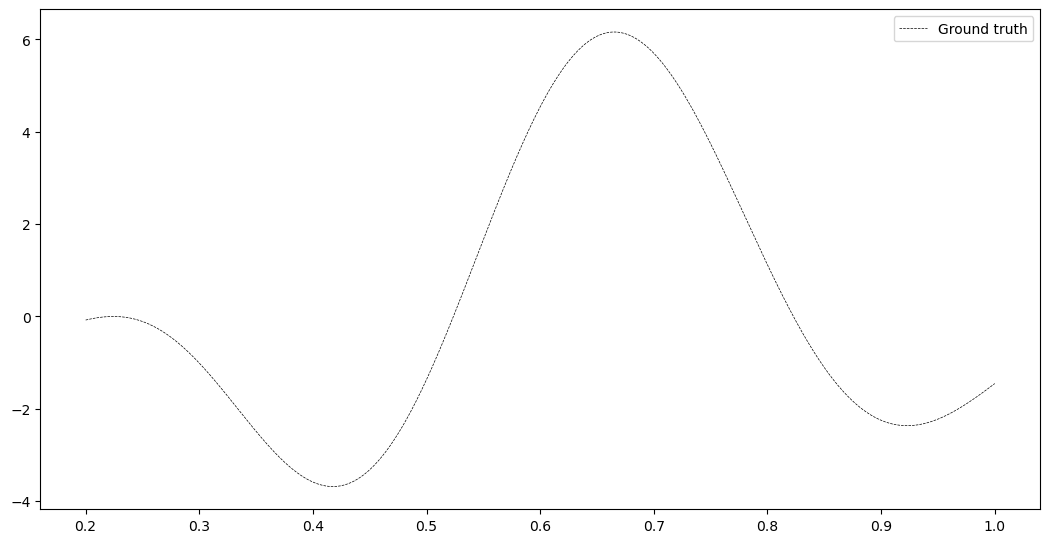

In [3]:
#range for sampling
xmin=0.2
xmax=1.00
points_plot=1000                              #resolution of the ground truth 
x_plot=np.linspace(xmin,xmax,points_plot) 
y_plot=function(x_plot)

fig = plt.figure(figsize=(10,5))
ax=fig.add_axes([0,0,1,1])
ax.plot(x_plot, y_plot,label=r"Ground truth",linestyle='dashed',linewidth=0.5,color='k')
# ax.scatter(t2,PC,label=r"Predictions",color='g',s=10)
# plt.scatter(xn, M, label="Observations",marker="x",color='r',s=200)
plt.legend(prop={'size': 10})

In [4]:
points_data=300                   
x_data=np.random.uniform(xmin,xmax,points_data) 
y_data=function(x_data)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=73)  # create splits

x_train = torch.from_numpy(x_train.astype(np.float32)).view(-1,1)
y_train = torch.from_numpy(y_train.astype(np.float32)).view(-1,1)

x_test = torch.from_numpy(x_test.astype(np.float32)).view(-1,1)
y_test = torch.from_numpy(y_test.astype(np.float32)).view(-1,1)

print('train size:',len(x_train))

train size: 240


In [5]:
# Active training
use_cuda = torch.cuda.is_available()
# for i in tqdm(range(epoch, nb_epochs)):

n_active_ep = 20
active_points = 5
mcs_samples = int(1e5)
it_count = 0

burn_in = 10   #How many epochs to burn in for?. Default: 20.
sim_steps = 2   #How many epochs pass between saving samples. Default: 2.
N_saves=10
resample_its = 50
resample_prior_its = 15
re_burn = 1e8

n_passive_ep = 200
batch_size = 64

train_loader, _ = get_dataloader(x_train, y_train, 1, 1, train_test_split=1.0, batch_size=batch_size)

net = BNN_SGHMC(N_train=len(x_train), input_dim=1, width=20, depth=2, output_dim=1, 
              lr=1e-2, cuda=use_cuda, grad_std_mul=10)

In [20]:
net.train(train_loader, epoch=n_passive_ep, burn_in=burn_in, re_burn = re_burn , 
              resample_its=resample_its, resample_prior_its = resample_prior_its, 
              sim_steps = sim_steps, N_saves=N_saves, verbose=0 )

train_loss = 0.077607,


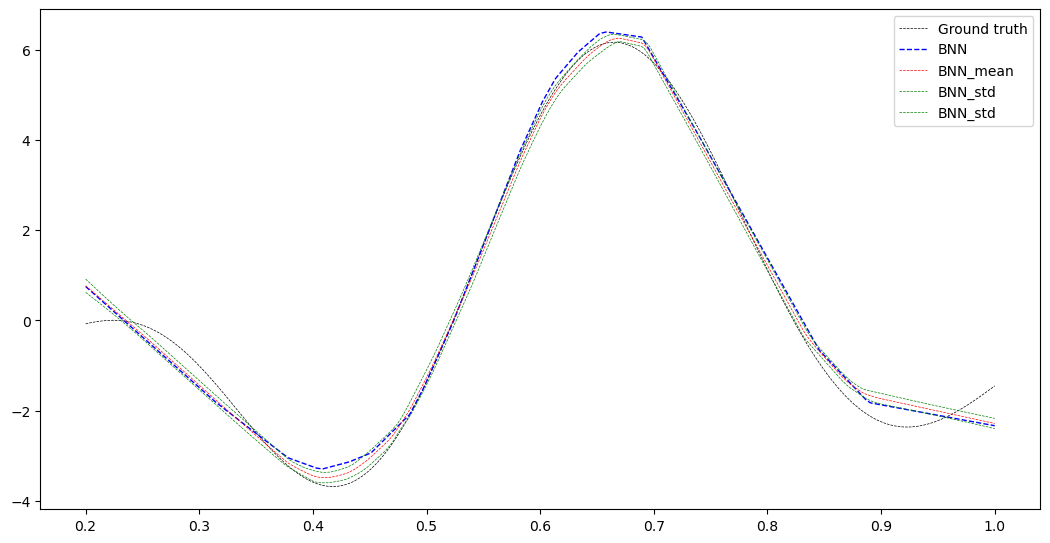

In [37]:
#range for sampling
points_plot=1000                              #resolution of the ground truth 
x_plot=np.linspace(xmin,xmax,points_plot) 
y_plot=function(x_plot)

x_train_net = torch.from_numpy(x_plot.astype(np.float32)).view(-1,1)
y_bnn = net.predict(x_train_net).cpu().detach().numpy()
y_bnn_pred = net.sample_predict(x_train_net, Nsamples=10).cpu().detach().numpy()
y_bnn_mean = np.mean(y_bnn_pred, axis=0)
y_bnn_std = np.std(y_bnn_pred, axis=0)

fig = plt.figure(figsize=(10,5))
ax=fig.add_axes([0,0,1,1])
ax.plot(x_plot, y_plot,label=r"Ground truth",linestyle='dashed',linewidth=0.5,color='k')
ax.plot(x_plot, y_bnn,label=r"BNN",linestyle='dashed',linewidth=1,color='b')
ax.plot(x_plot, y_bnn_mean,label=r"BNN_mean",linestyle='dashed',linewidth=0.5,color='r')
ax.plot(x_plot, y_bnn_mean+y_bnn_std,label=r"BNN_std",linestyle='dashed',linewidth=0.5,color='g')
ax.plot(x_plot, y_bnn_mean-y_bnn_std,label=r"BNN_std",linestyle='dashed',linewidth=0.5,color='g')
# ax.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())
# ax.scatter(t2,PC,label=r"Predictions",color='g',s=10)
# plt.scatter(xn, M, label="Observations",marker="x",color='r',s=200)
plt.legend(prop={'size': 10})